In [1]:
!pip install gpflow
!pip install utils
!pip install cartopy
!apt-get -qq install python-cartopy python3-cartopy
!pip uninstall -y shapely    # cartopy and shapely aren't friends (early 2020)
!pip install shapely --no-binary shapely


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 376.8/376.8 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 64.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 6.2 MB/s eta 0:00:00
  Created wheel for cartopy: filename=Cartopy-0.21.1-cp310-cp310-linux_x86_64.whl size=11102750 sha256=e342e593d133386d41658a265165adeff838372b05cfa4abbf5359beec8a529e
  Stored in directory: /root/.cache/pip/wheels/30/b0/1a/1c1909e00c76653dc4e2ff48555257c0eb2d1698280c8d9955
Successfully built cartopy
E: Unable to locate package python-cartopy
Found existing installation: shapely 2.0.1
Uninstalling shapely-2.0.1:
  Successfully uninstalled shapely-2.0.1
     

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import xarray as xr
from glob import glob

import tensorflow as tf
import gpflow
from utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

In [3]:
from google.colab import drive


drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


Utilis

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob


def make_dir(path):
    if os.path.exists(path) is False:
        os.makedirs(path)


def prepare_predictor(data_sets, data_path,time_reindex=True):
    """
    Args:
        data_sets list(str): names of datasets
    """

    # Create training and testing arrays
    if isinstance(data_sets, str):
        data_sets = [data_sets]

    X_all      = []
    length_all = []

    for file in data_sets:
        data = xr.open_dataset(os.path.join(data_path, f"inputs_{file}.nc"))
        X_all.append(data)
        length_all.append(len(data.time))

    X = xr.concat(X_all,dim='time')
    length_all = np.array(length_all)
    # X = xr.concat([xr.open_dataset(data_path + f"inputs_{file}.nc") for file in data_sets], dim='time')
    if time_reindex:
        X = X.assign_coords(time=np.arange(len(X.time)))

    return X, length_all

def prepare_predictand(data_sets,data_path,time_reindex=True):
    if isinstance(data_sets, str):
        data_sets = [data_sets]

    Y_all = []
    length_all = []

    for file in data_sets:
        data = xr.open_dataset(os.path.join(data_path, f"outputs_{file}.nc"))
        Y_all.append(data)
        length_all.append(len(data.time))

    length_all = np.array(length_all)
    Y = xr.concat(Y_all,dim='time').mean('member')
    # Y = xr.concat([xr.open_dataset(data_path + f"outputs_{file}.nc") for file in data_sets], dim='time').mean("member")
    Y = Y.rename({'lon':'longitude','lat': 'latitude'}).transpose('time','latitude', 'longitude').drop(['quantile'])
    if time_reindex:
        Y = Y.assign_coords(time=np.arange(len(Y.time)))

    return Y, length_all


def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.latitude))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['latitude', 'longitude'])).data.mean()

def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean squared error')
    plt.plot(history.epoch, np.array(history.history['loss']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val loss')
    plt.legend()




# Utilities for normalizing the input data
def normalize(data, var, meanstd_dict):
    mean = meanstd_dict[var][0]
    std = meanstd_dict[var][1]
    return (data - mean)/std

def mean_std_plot(data,color,label,ax):

    mean = data.mean(['latitude','longitude'])
    std  = data.std(['latitude','longitude'])
    yr   = data.time.values

    ax.plot(yr,mean,color=color,label=label,linewidth=4)
    ax.fill_between(yr,mean+std,mean-std,facecolor=color,alpha=0.4)

    return yr, mean

In [5]:
cwd = os.getcwd()

train_path = os.path.join(cwd,'/content/gdrive/MyDrive/climate_emulator_duncan_parris/','train_val1')
test_path  = os.path.join(cwd,'/content/gdrive/MyDrive/climate_emulator_duncan_parris/','train_val1')

make_dir(train_path)
make_dir(test_path)

In [6]:
# Training set
train_files = ["historical", "ssp585", "ssp126", "ssp370","hist-aer","hist-GHG"]
X_train_xr, X_length  = prepare_predictor(train_files,train_path)
y_train_xr, y_length  = prepare_predictand(train_files,train_path)

# Test set
X_test_xr, _ = prepare_predictor('ssp245', data_path=test_path,time_reindex=False)
y_test_xr, _ = prepare_predictand('ssp245',data_path=test_path,time_reindex=False)

In [7]:
X_train_df = pd.DataFrame({"CO2": X_train_xr["CO2"].data,
                           "CH4": X_train_xr["CH4"].data
                          }, index=X_train_xr["CO2"].coords['time'].data)

X_test_df  = pd.DataFrame({"CO2": X_test_xr["CO2"].data,
                           "CH4": X_test_xr["CH4"].data
                          }, index=X_test_xr["CO2"].coords['time'].data)


y_train_df = y_train_xr["tas"].stack(dim=["latitude", "longitude"])
y_train_df = pd.DataFrame(y_train_df.to_pandas())

Data standarization

In [8]:
# Standardize the predictors
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
X_test  = X_test_df.to_numpy()

In [9]:
# Standardize the predictand
y_train    = y_train_df.to_numpy().astype(np.float64)
train_pr_mean, train_pr_std = y_train.mean(), y_train.std()
y_train    = (y_train - train_pr_mean) / train_pr_std


print(X_train.shape,y_train.shape,X_test.shape)

(753, 2) (753, 13824) (86, 2)


In [10]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV

krr =  krr = KernelRidge(alpha=1.0,kernel="rbf", gamma=0.1)

model = MultiOutputRegressor(krr)

# Fit the model
model.fit(X_train, y_train)


MultiOutputRegressor(estimator=KernelRidge(alpha=1.0, gamma=0.1, kernel='rbf'))

In [11]:
# predict
standard_posterior_mean =  model.predict(X_test)
standard_posterior_var = model.predict(X_test)
posterior_mean   = standard_posterior_mean * train_pr_std + train_pr_mean
posterior_std    = np.sqrt(standard_posterior_var) * train_pr_std
y_test_pre_mean = np.reshape(posterior_mean,[posterior_mean.shape[0], 96, 144])
y_test_pre_std  = np.reshape(posterior_std,[posterior_std.shape[0], 96, 144])

y_test_pre = xr.Dataset(coords={'time': X_test_xr.time.values,
                                 'latitude': X_test_xr.latitude.values,
                                 'longitude': X_test_xr.longitude.values},
                             data_vars=dict(tas_mean=(['time', 'latitude', 'longitude'], y_test_pre_mean),
                                            tas_std=(['time', 'latitude', 'longitude'], y_test_pre_std)))

<ipython-input-11-25d21cfd0c5d>:5: RuntimeWarning: invalid value encountered in sqrt
  posterior_std    = np.sqrt(standard_posterior_var) * train_pr_std


In [12]:
standard_posterior_var = np.clip(standard_posterior_var, a_min=0.0, a_max=None)
posterior_std = np.sqrt(standard_posterior_var) * train_pr_std

In [19]:
y_test_xr

<xarray.Dataset>
Dimensions:                    (latitude: 96, longitude: 144, time: 86)
Coordinates:
  * latitude                   (latitude) float64 -90.0 -88.11 ... 88.11 90.0
  * longitude                  (longitude) float64 0.0 2.5 5.0 ... 355.0 357.5
  * time                       (time) int64 2015 2016 2017 ... 2098 2099 2100
Data variables:
    diurnal_temperature_range  (time, latitude, longitude) float32 0.09798 .....
    tas                        (time, latitude, longitude) float32 1.475 ... ...
    pr                         (time, latitude, longitude) float32 3.614e-07 ...
    pr90                       (time, latitude, longitude) float64 8.739e-07 ...

In [20]:
# put output back into pd.DataFrame format for calculating RMSE/plotting
posterior_tas = np.reshape(posterior_mean, [86, 96, 144])
posterior_tas_std = np.reshape(posterior_std, [86, 96, 144])
posterior_tas_data = xr.DataArray(posterior_tas, dims=y_test_xr.tas.dims, coords=y_test_xr.tas.coords)
posterior_tas_std_data = xr.DataArray(posterior_tas_std, dims=y_test_xr.tas.dims, coords=y_test_xr.tas.coords)

In [13]:
# Compute RMSEs
print(f"RMSE at 2050: {get_rmse(y_test_xr.tas[35], y_test_pre.tas_mean[35])}")
print(f"RMSE at 2100: {get_rmse(y_test_xr.tas[85], y_test_pre.tas_mean[85])}")
print(f"RMSE 2045-2055: {get_rmse(y_test_xr.tas[30:41], y_test_pre.tas_mean[30:41]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(y_test_xr.tas[75:], y_test_pre.tas_mean[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(y_test_xr.tas[35:], y_test_pre.tas_mean[35:]).mean()}")

# RMSE for average field over the last 20 years
print(f"RMSE average last 20y: {get_rmse(y_test_xr.tas[-20:].mean(dim='time'), y_test_pre.tas_mean[-20:].mean(dim='time'))}")

RMSE at 2050: 0.3371089269351109
RMSE at 2100: 0.35185287320849906
RMSE 2045-2055: 0.3569342305699383
RMSE 2090-2100: 0.38257365314695196
RMSE 2050-2100: 0.37948137748026495
RMSE average last 20y: 0.2278101709800473


[Text(0.5, 1.0, 'Difference')]

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


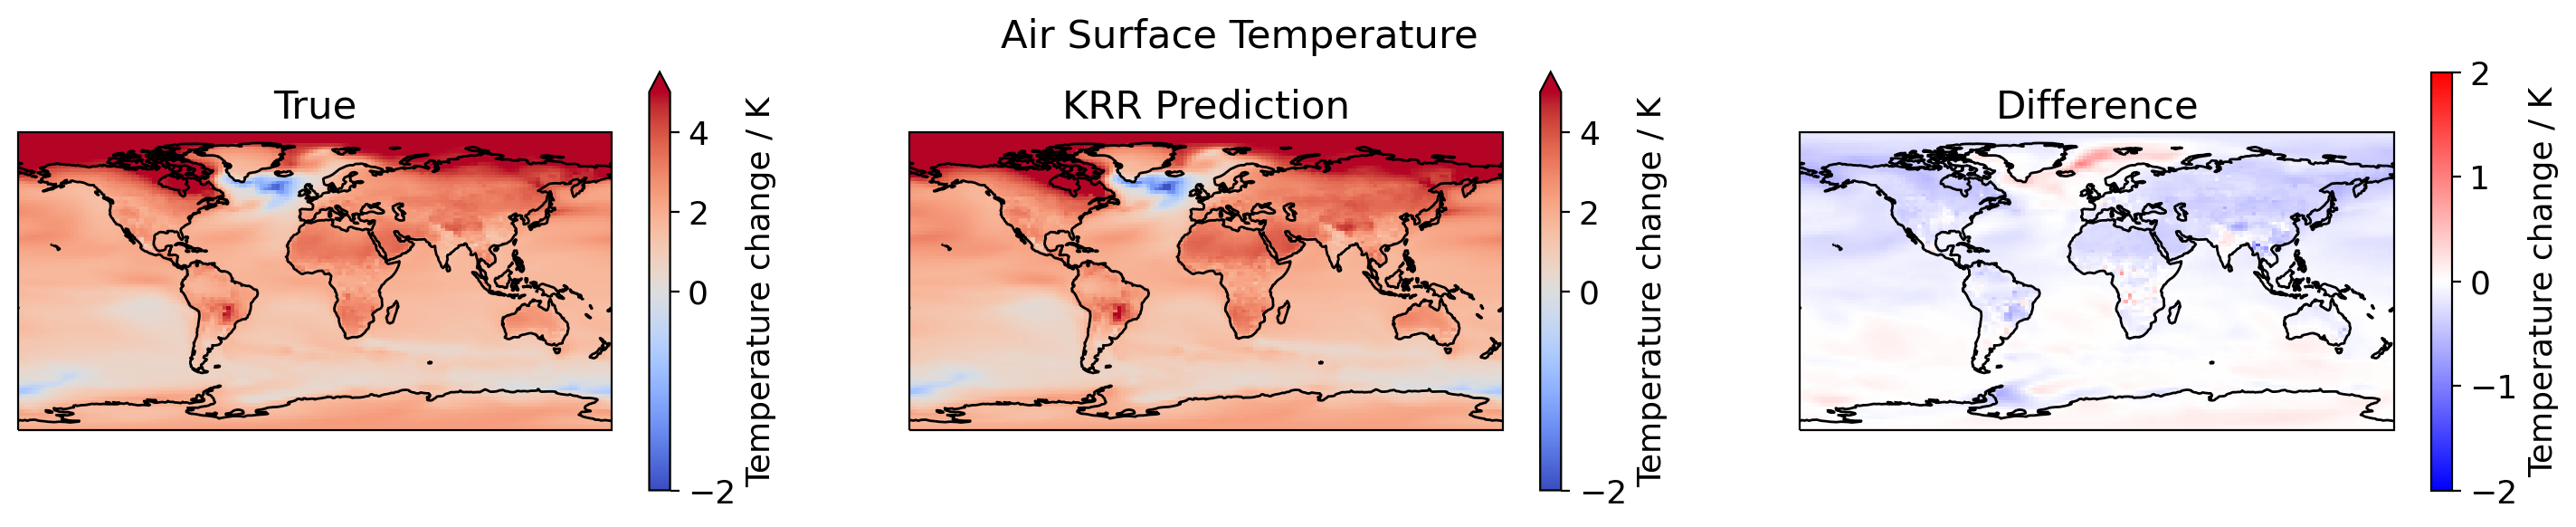

In [14]:
import cartopy.crs as ccrs
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Air Surface Temperature')

# Test
plt.subplot(131, projection=proj)
y_test_xr.tas.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
y_test_pre.tas_mean.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                       cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='KRR Prediction')

# Difference
difference = y_test_xr.tas - y_test_pre.tas_mean
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

In [21]:
# Save predictions
posterior_tas_data.to_netcdf('/content/gdrive/MyDrive/climatebench-krr-posterior-mean-dtr-test-2019-2100.nc')
posterior_tas_std_data.to_netcdf('/content/gdrive/MyDrive/climatebench-krr-pposterior-std-dtr-test-2019-2100.nc')

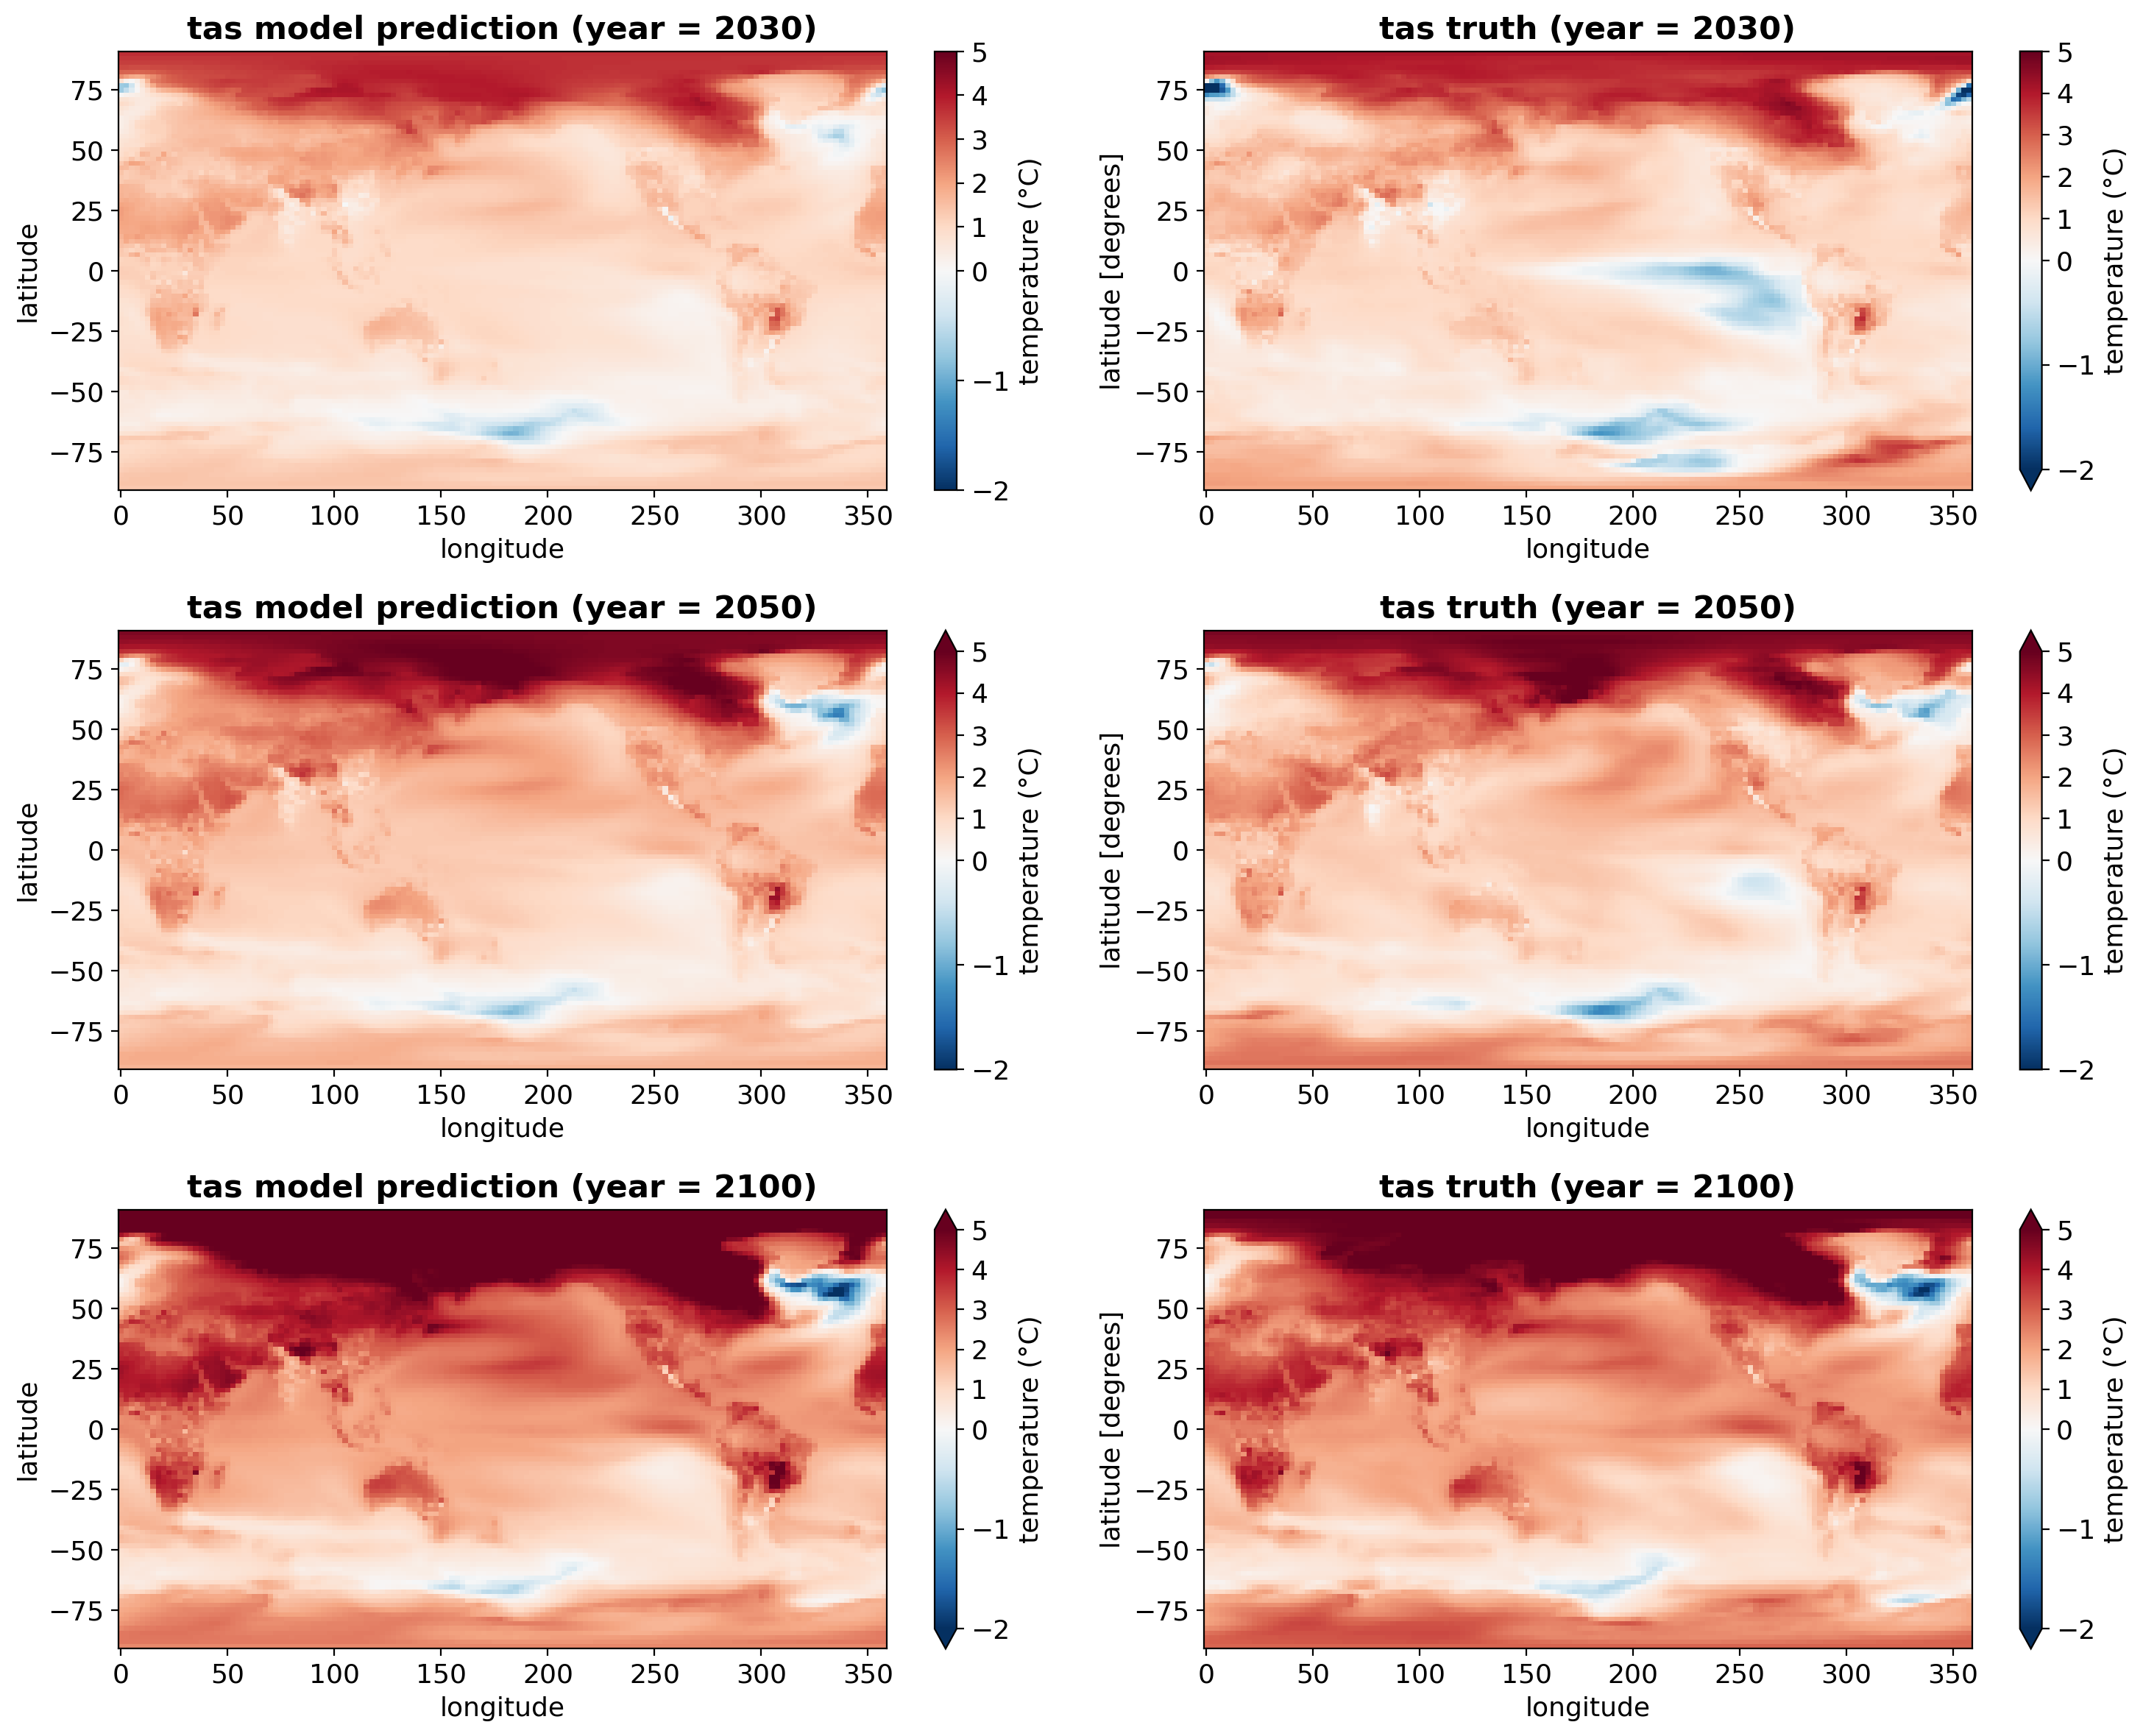

In [ ]:
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=3)

yrs = [2030, 2050, 2100]
vmin, vmax    = -2, 5
cmap = 'RdBu_r'
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0., vmax=vmax)
# diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

y_test_pre.tas_mean.sel(time=yrs[0]).plot(ax=axes[0,0], cmap=cmap,norm=divnorm,
                                          cbar_kwargs={"label":"temperature (°C)"})
y_test_xr.tas.sel(time=yrs[0]).plot(ax=axes[0,1], cmap=cmap,norm=divnorm,
                                    cbar_kwargs={"label":"temperature (°C)"})

y_test_pre.tas_mean.sel(time=yrs[1]).plot(ax=axes[1,0], cmap=cmap,norm=divnorm,
                                          cbar_kwargs={"label":"temperature (°C)"})
y_test_xr.tas.sel(time=yrs[1]).plot(ax=axes[1,1], cmap=cmap,norm=divnorm,
                                    cbar_kwargs={"label":"temperature (°C)"})

y_test_pre.tas_mean.sel(time=yrs[2]).plot(ax=axes[2,0], cmap=cmap,norm=divnorm,
                                          cbar_kwargs={"label":"temperature (°C)"})
y_test_xr.tas.sel(time=yrs[2]).plot(ax=axes[2,1], cmap=cmap,norm=divnorm,
                                    cbar_kwargs={"label":"temperature (°C)"})


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 2 == 0:
        ax.set_title(f'tas model prediction (year = {yrs[i//2]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'tas truth (year = {yrs[i//2]})',fontweight='bold')
plt.tight_layout()